In [1]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

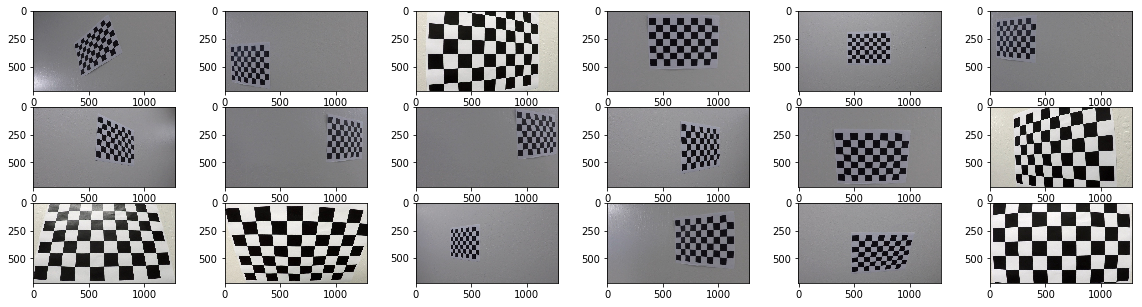

In [3]:
# show images
def show_images(images_list, cols=1):
    '''
    para: images_list, list of arrays
    '''
    fig = plt.figure(figsize=(20, 5))
    length = len(images_list)
    rows = length // cols
    for index in range(1, length-1):
        fig.add_subplot(rows, cols, index)
        plt.imshow(images_list[index], cmap='gray')
    plt.show()

# test show_images
images_list = [plt.imread(image) for image in images]
show_images(images_list, 6)

In [4]:
# Step through the list and search for chessboard corners
des_images = []
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        des_images.append(cv2.drawChessboardCorners(img, (9,6), corners, ret))

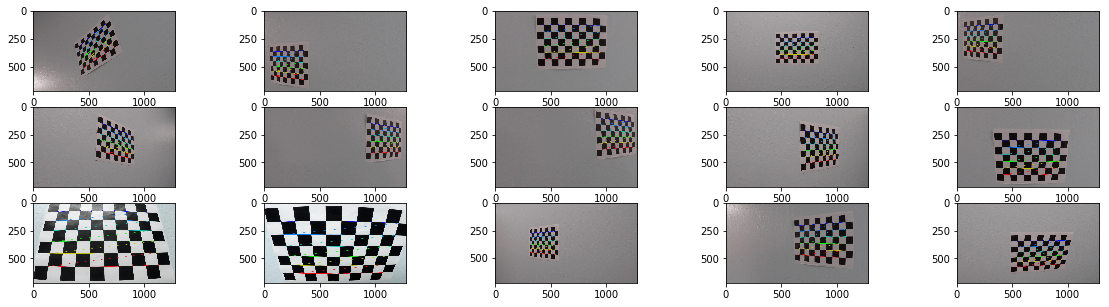

In [5]:
show_images(des_images, 5)

In [6]:
image_size = des_images[0].shape

In [7]:
image_size

(721, 1281, 3)

In [8]:
# calibrate camera
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720, 1280), None, None)

In [9]:
# distort images
des = cv2.undistort(des_images[0], cameraMatrix, distCoeffs)

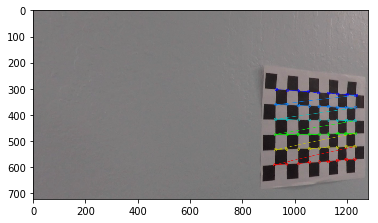

In [10]:
plt.imshow(des)

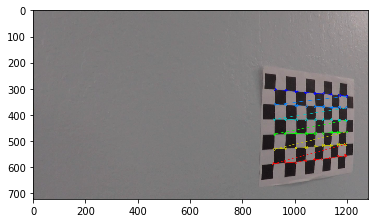

In [11]:
plt.imshow(des_images[0])

In [12]:
undistort_images = [cv2.undistort(image, cameraMatrix, distCoeffs) for image in images_list]

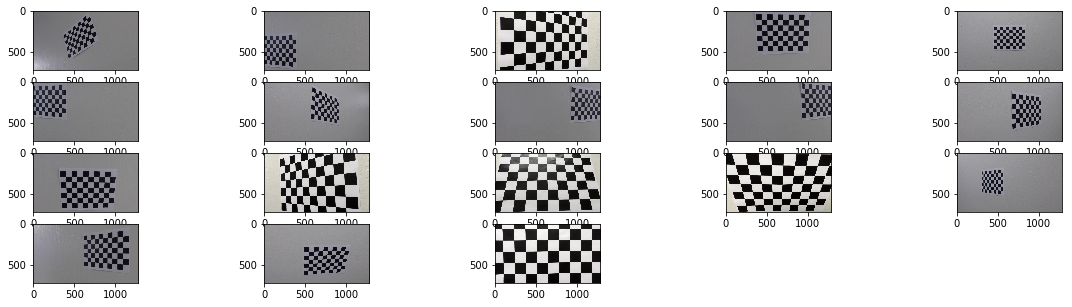

In [13]:
show_images(undistort_images, 5)

In [14]:
objpoints[0].shape

(54, 3)

## log
1. 尝试使用单个图片的3D真实坐标和cv找到的棋盘上的点来标定相机, 报错, 需要使用多个点以及多个相机corners.
    - 解答: 标定相机需要至少2个标定数据, 一个是不够的.
2. BUG: objectPoints should contain vector of vectors of points of type Point3f
    - 解决: 类型错误, 应该是float32的类型, np.zeros的默认类型是float64.

In [15]:
nx, ny = 9, 6 # nx, ny for pattern.
# objpoints = np.zeros((nx * ny, 3), np.float32) # for one image.
# objpoints[:, :2] = np.mgrid[:nx,:ny].T.reshape(-1, 2)
objpoints = np.zeros((6*9,3), np.float32)
objpoints[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objpoints_list = [] # for list of images
imagepoints_list = []
image_shape = images_list[0].shape[:-1]
height, width = image_shape
patternsize = (nx, ny)

In [16]:
objpoints.shape

(54, 3)

In [17]:
# undistort and transform perspective
for image in images_list:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)    
    ret, corners = cv2.findChessboardCorners(image, patternsize)
    if ret:
        imagepoints_list.append(corners)
        objpoints_list.append(objpoints)
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints_list, imagepoints_list, image_shape, None, None)
undistort_images_list = [cv2.undistort(image, cameraMatrix, distCoeffs) for image in images_list]

### NOTE
- getPerspectiveTransform的参数
    - src: 真实世界中的四个顶点坐标.
        - 这个就是棋盘的四个顶点坐标.
    - dst: 输出图片的四个对应坐标.
        - 这个是图片的四个顶点, 和图片的尺寸有关.

In [18]:
for index in (0, ny-1, -1, -nx):
    print(objpoints[index])

[ 0.  0.  0.]
[ 5.  0.  0.]
[ 8.  5.  0.]
[ 0.  5.  0.]


### LOG
1. BUG: 生成的图片的尺寸有问题, 拉长了.
    - 猜测原因: object points的坐标有问题.
        - 添加offset, 查看效果

[array([ 0.,  0.,  0.], dtype=float32), array([ 8.,  0.,  0.], dtype=float32), array([ 8.,  5.,  0.], dtype=float32), array([ 0.,  5.,  0.], dtype=float32)]
[[    0.     0.]
 [ 1281.     0.]
 [ 1281.   721.]
 [    0.   721.]]


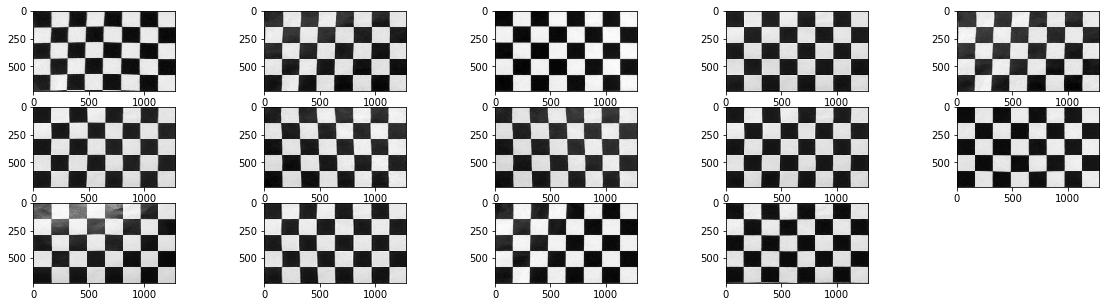

In [19]:
warp_list = []
for undistort_image in undistort_images_list:
    undistort_image = cv2.cvtColor(undistort_image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(undistort_image, patternsize)
    if ret:
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([(0,0), (width, 0), (width, height), (0, height)])
        M = cv2.getPerspectiveTransform(src, dst)
        warp_list.append(cv2.warpPerspective(undistort_image, M, (width, height)))
print([objpoints[index] for index in [0, nx-1, -1, -nx]])
print(dst)
show_images(warp_list, 5)

### NOTE
1. 使用课程里面的代码, 没有错误, 分析结果出错的原因.

## PIPELINE: test images

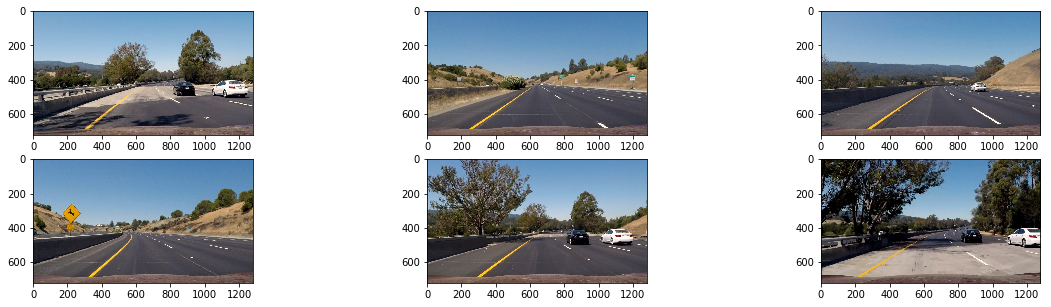

In [20]:
# Example of a distorted image.
test_images_dir = './test_images/'

test_images = glob.glob(test_images_dir+'*.jpg')

show_images([plt.imread(image) for image in test_images], 3)

In [21]:
# create a function to get camera calibration matrix
def camera_calibration(images, patternsize=(9, 6)):
    '''images: chess board images list of numpy array'''
    objpoints = []
    imgpoints = []
    nx = patternsize[0]
    ny = patternsize[1]
    objpoint = np.zeros((nx * ny, 3), np.float32)
    objpoint[:, :2] = np.mgrid[:nx, :ny].T.reshape((-1, 2))
    imagesize = images[0].shape[:-1]
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(image, patternsize)
        if ret:
            objpoints.append(objpoint)
            imgpoints.append(corners)
    ret, cameraMatrix, distCoeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imagesize, None, None)
    return cameraMatrix, distCoeff

In [22]:
# test camera_calibration
camera_calibration(images_list)

(array([[  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
        [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[-0.24688507, -0.02373154, -0.00109831,  0.00035107, -0.00259869]]))

In [23]:
# Create a function to undistot the image.
def undistort(image, matrix, dis):
    '''image: 3 channel numpy array'''
    return cv2.undistort(image, matrix, dis)

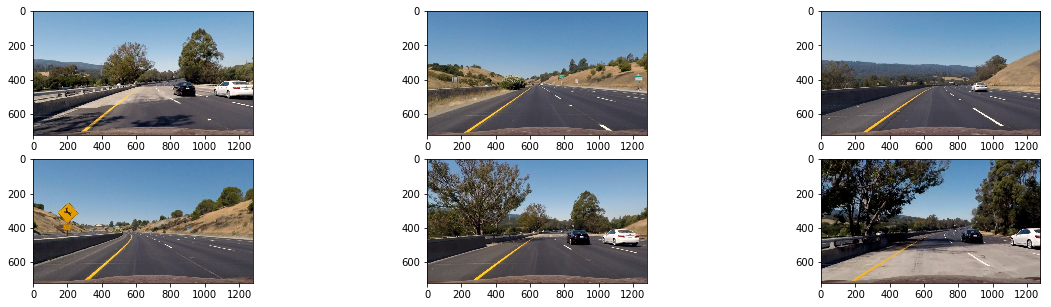

In [24]:
# test undistort
matrix, dis = camera_calibration(images_list)

test_images_list = [plt.imread(image) for image in test_images]

show_images([undistort(image, matrix, dis) for image in test_images_list], 3)

### NOTE
1. 这里如果每次都手动选四个点是不现实的, 所以需要用颜色或者别的fileter来找到四个点.

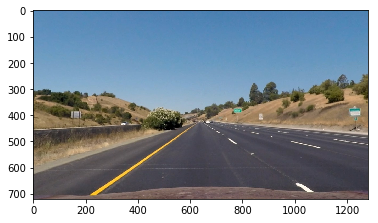

In [25]:
straight_line = './test_images/straight_lines1.jpg'

staright_line_image = undistort(plt.imread(straight_line), matrix, dis)

plt.imshow(staright_line_image)

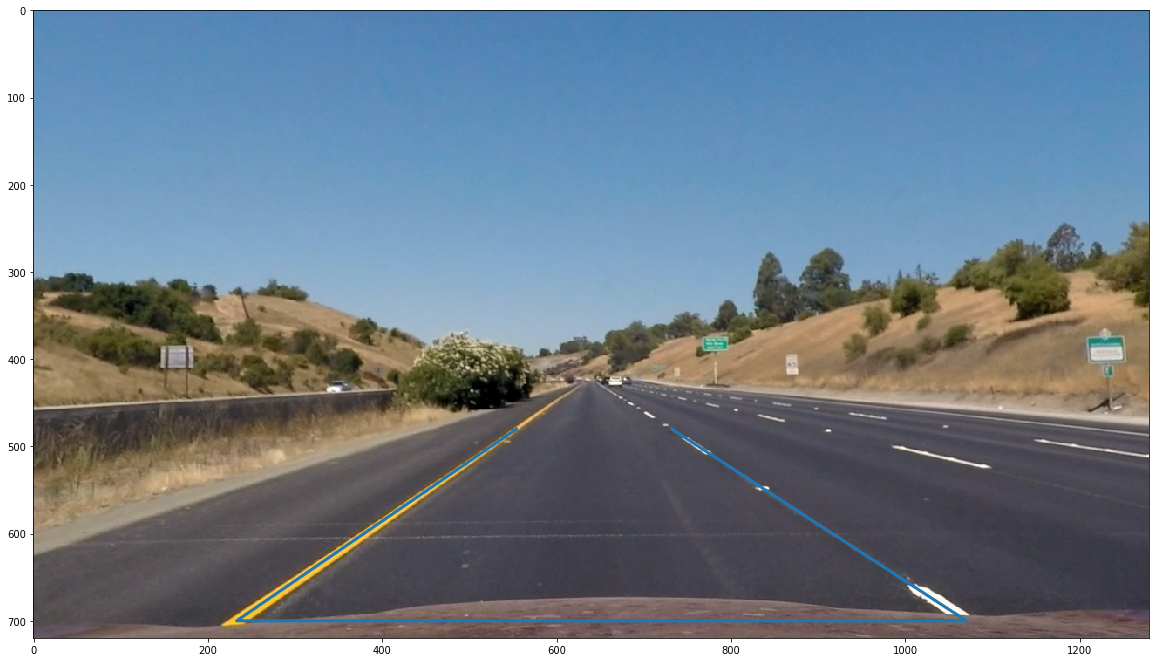

In [28]:
# Show image in gray and cut the view with four points.
firstline = 480
secondline = 700
x1 = 554
x2 = 233
x3 = 1070
x4 = 732

first_point = (x1, firstline)
second_point = (x2, secondline)
third_point = (x3, secondline)
fourth_point = (x4, firstline)
src = np.float32([first_point, second_point, third_point, fourth_point])
dst = np.float32([(x2, 0), (x2, 720), (x3, 720), (x3, 0)])

fig = plt.figure(figsize=(20, 20))
plt.imshow(staright_line_image)
plt.plot(src.T[0], src.T[1], linewidth=3)

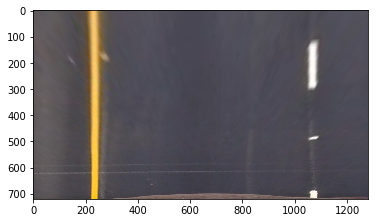

In [29]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
plt.imshow(cv2.warpPerspective(staright_line_image, M, (1280,720)))

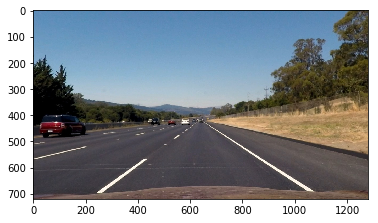

In [30]:
# chage another staright line to test

staright_line_image = undistort(test_images_list[0], matrix, dis)

plt.imshow(staright_line_image,)

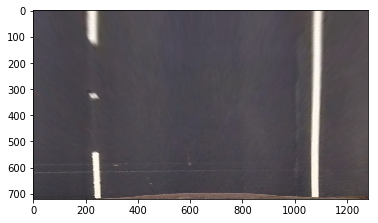

In [31]:
plt.imshow(cv2.warpPerspective(staright_line_image, M, (1280,720)))

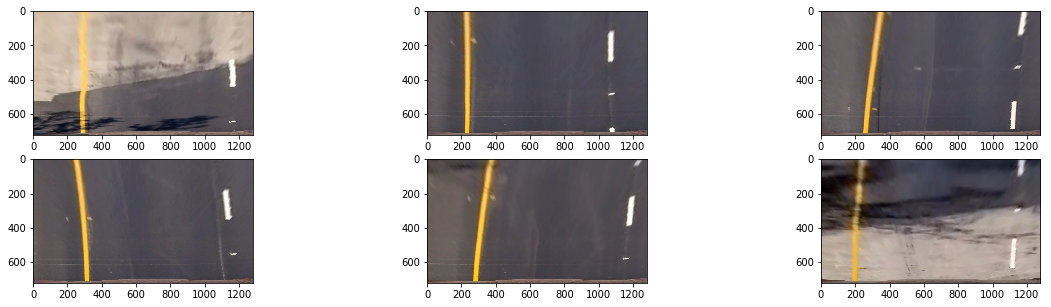

In [32]:
show_images([cv2.warpPerspective(image, M, (1280, 720)) for image in test_images_list], 3)

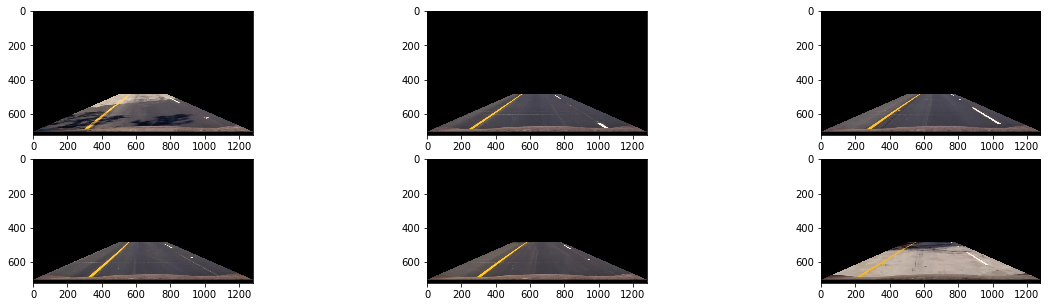

In [33]:
# 把鸟瞰图转成原图看看位置
warp_images = [cv2.warpPerspective(image, M, (1280, 720)) for image in test_images_list]

show_images([cv2.warpPerspective(image, Minv, (1280, 720)) for image in warp_images], 3)

### LOG
1. 下一步做filter, 搞出来识别线.
    1. 颜色识别. Sobel operator.
    2. magnitude of the gradient.
    3. direction of the gradient.

# Note
1. 出现的图是全黑的.
    - 猜测可能的原因是梯度的方向不对, 改为y作为方向.
        - 一样不可以
    - 使用不同的threshold.
        - 不行
    - 检查像素值.
    - 原因: scale的值去判断而不是, 用错了值.

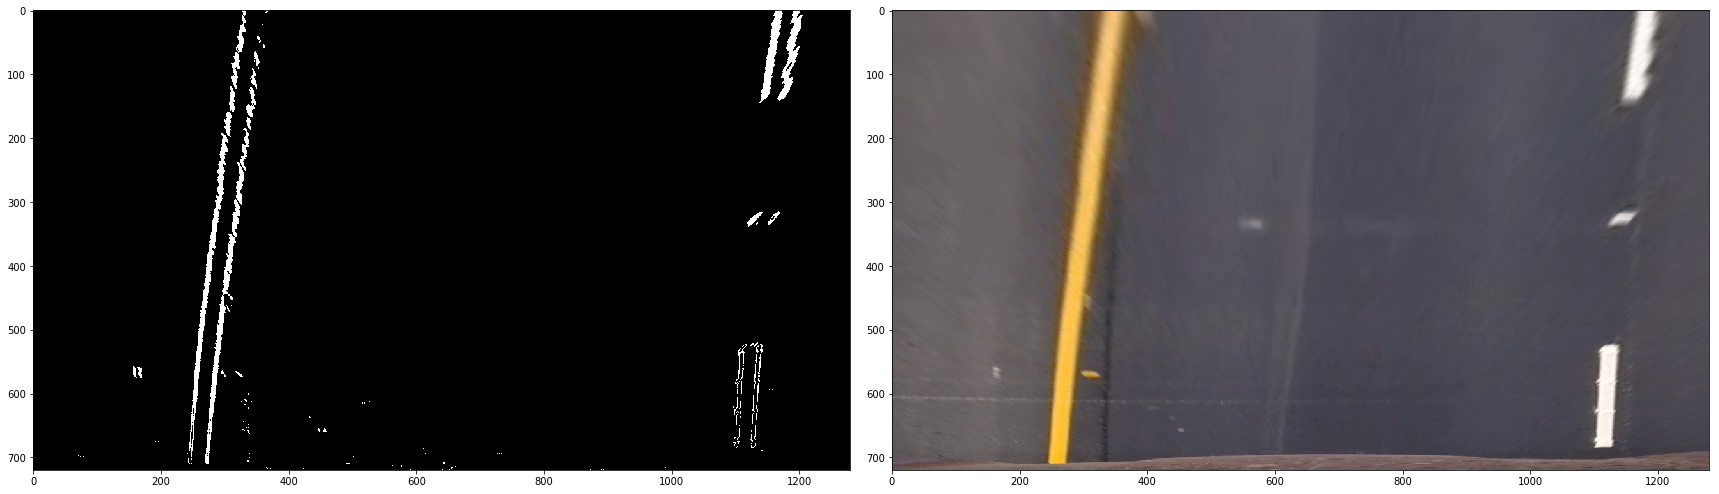

In [34]:
def abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100):
    # Grayscale
    # Apply cv2.Sobel()
    # Take the absolute value of the output from cv2.Sobel()
    # Scale the result to an 8-bit range (0-255)
    # Apply lower and upper thresholds
    # Create binary_output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    absolute_value = np.absolute(sobel)
    scale_sobel = np.uint8(absolute_value*255/np.max(absolute_value))
    binary_output = np.zeros_like(scale_sobel)
    binary_output[(scale_sobel >= thresh_min) & (scale_sobel <= thresh_max)] = 1
    return binary_output

# test sobel_image
_testimage = cv2.warpPerspective(plt.imread('./test_images/test3.jpg'), M, (1280,720))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(abs_sobel_thresh(_testimage,'x'), 'gray')
ax2.imshow(_testimage)

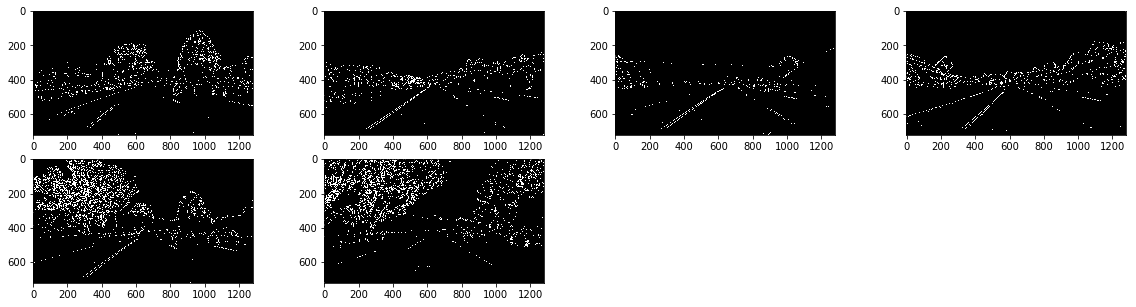

In [37]:
# use the sobel to convert images to gradient.
sobeled_images = [abs_sobel_thresh(img) for img in test_images_list]
show_images(sobeled_images, 4)

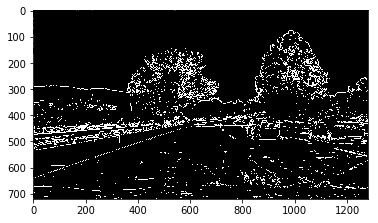

In [38]:
# threshold for x and y directions.
def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.sqrt(np.power(sobelx, 2))
    abs_sobely = np.sqrt(np.power(sobely, 2))
    abs_sobelxy = np.sqrt(np.power(sobelx,2)+np.power(sobely, 2))
    scale_sobelxy = 255 * abs_sobelxy / np.max(abs_sobelxy)
    binary_output = np.zeros(scale_sobelxy.shape)
    mask = (scale_sobelxy < mag_thresh[1]) & (scale_sobelxy > mag_thresh[0])
    binary_output[mask] = 1
    return binary_output
# test
plt.imshow(mag_thresh(cv2.imread('./test_images/test1.jpg')), 'gray')

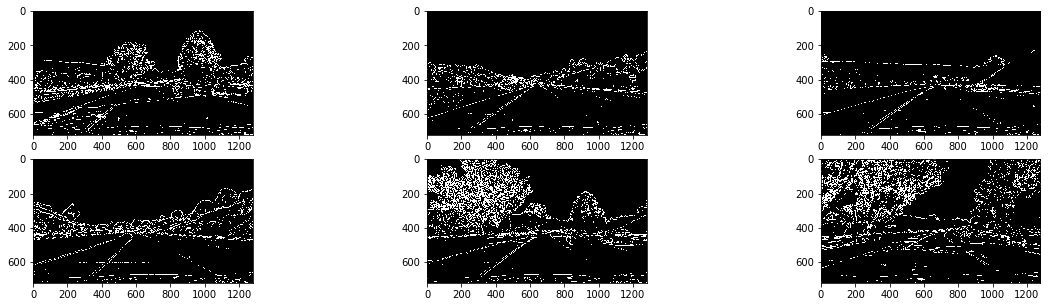

In [39]:
show_images([mag_thresh(img) for img in test_images_list], 3)

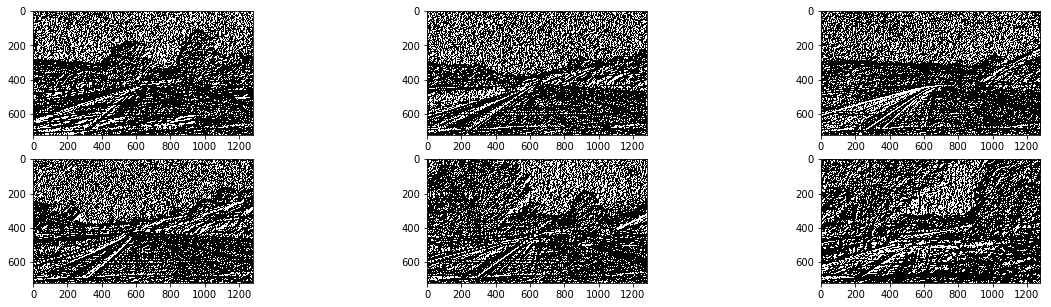

In [40]:
def dir_threshold(img, sobel_kernel=15, thresh=(0.4, 0.9)):    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, -1, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, -1, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros(abs_sobelx.shape)
    mask = (direction>=thresh[0]) & (direction<=thresh[1])
    binary_output[mask] = 1 # Remove this line
    return binary_output
# test
show_images([dir_threshold(img) for img in test_images_list], 3)

In [41]:
# combine each thresh
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel_image = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel_image = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absolute_sobel = np.absolute(sobel_image)
    scale_sobel = np.uint8(255 * absolute_sobel / np.max(absolute_sobel))
    grad_binary = np.zeros_like(scale_sobel)
    grad_binary[(scale_sobel > thresh[0]) & (scale_sobel < thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale = np.uint8(gradmag * 255 / np.max(gradmag))
    mag_binary = np.zeros_like(scale)
    mag_binary[(scale >= mag_thresh[0]) & (scale <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

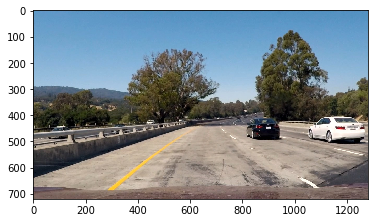

In [42]:
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements
image = cv2.imread('./test_images/test1.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, 'x', ksize, (10, 50))
plt.imshow(gradx, 'gray')

mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
plt.imshow(mag_binary, 'gray')

dir_binary = dir_threshold(image, ksize, (1.2, 1.9))
plt.imshow(dir_binary, 'gray')

# combined thresholds
combined = np.zeros_like(dir_binary)
combined[(gradx == 1) & (mag_binary == 1)] = 1
plt.imshow(combined, 'gray')

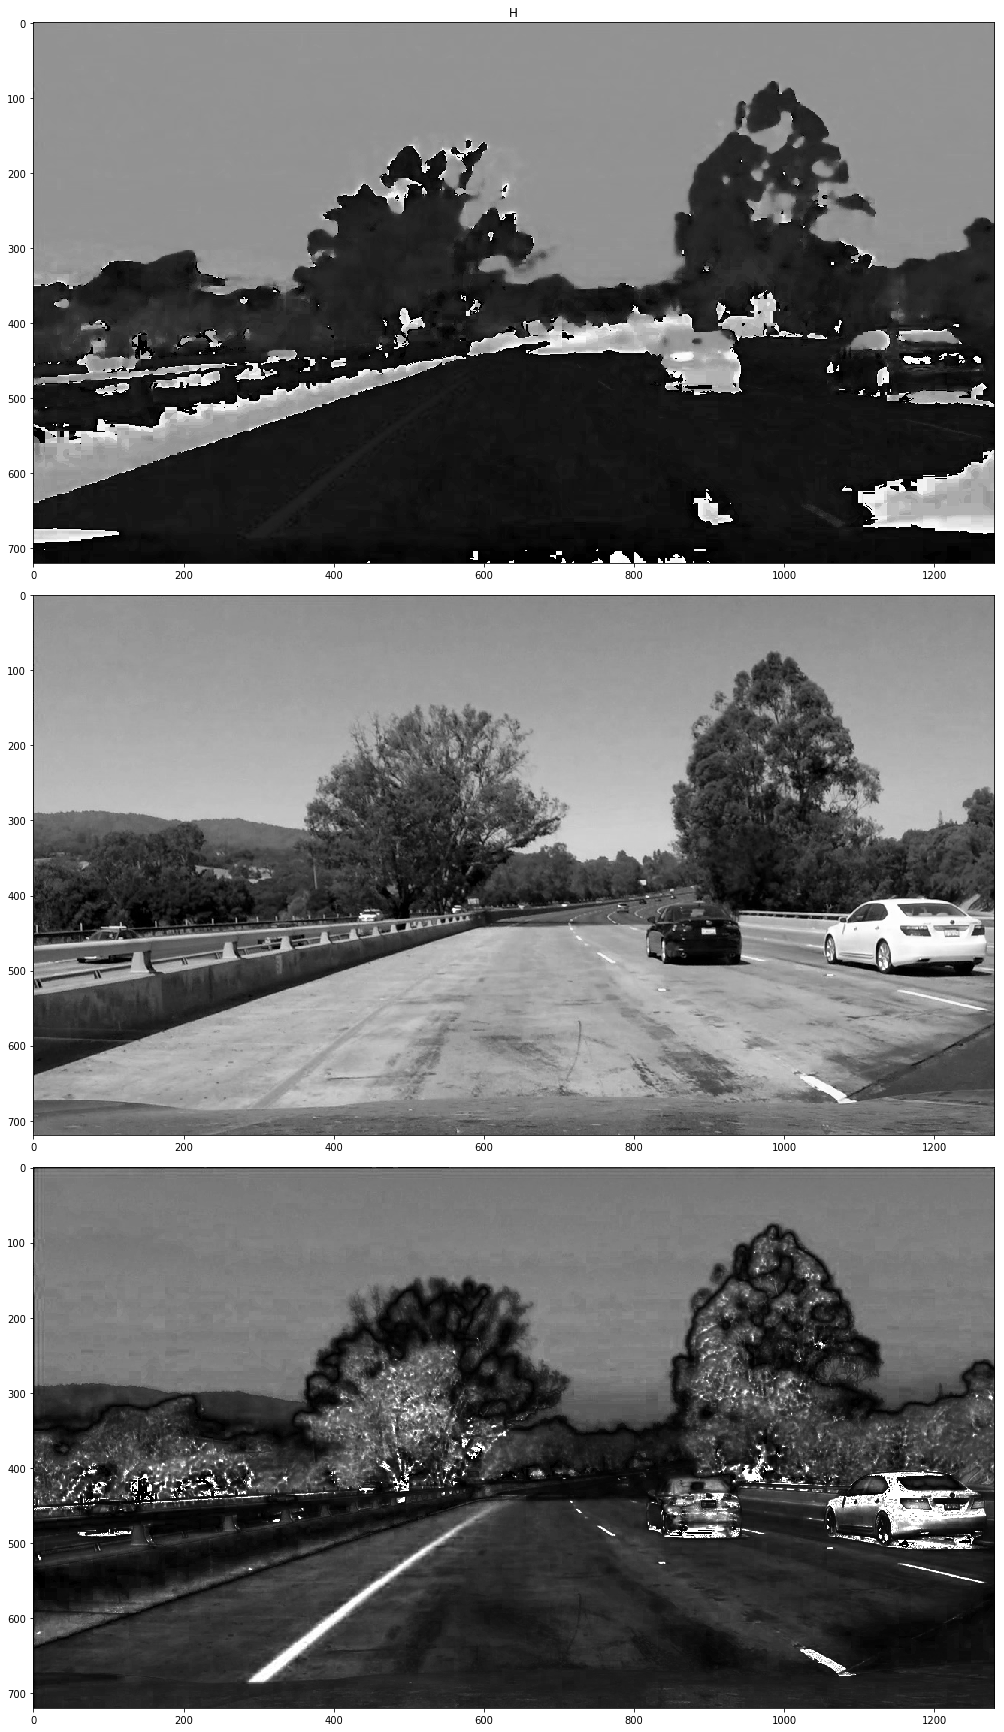

In [47]:
# HLS color thresholds
HLS_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
H = HLS_image[:, :, 0]
L = HLS_image[:, :, 1]
S = HLS_image[:, :, 2]
fig, axes = plt.subplots(3, 1, figsize=(20, 24))
fig.tight_layout()
axes[0].imshow(H, 'gray')
axes[0].set_title('H')
axes[1].imshow(L, 'gray')
axes[2].imshow(S, 'gray')

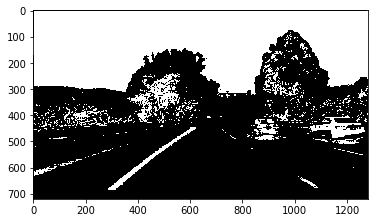

In [48]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(binary, 'gray')

In [49]:
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(image, thresh=(90, 255))

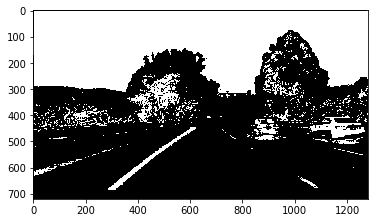

In [50]:
plt.imshow(hls_binary, 'gray')

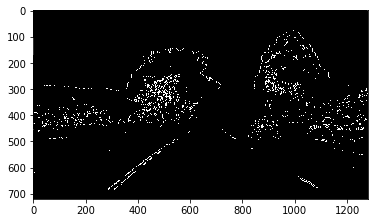

In [51]:
# combine color and gradient thresholds
combined = np.zeros_like(hls_binary)
combined[(gradx == 1) & (hls_binary == 1)] = 1
plt.imshow(combined, 'gray')

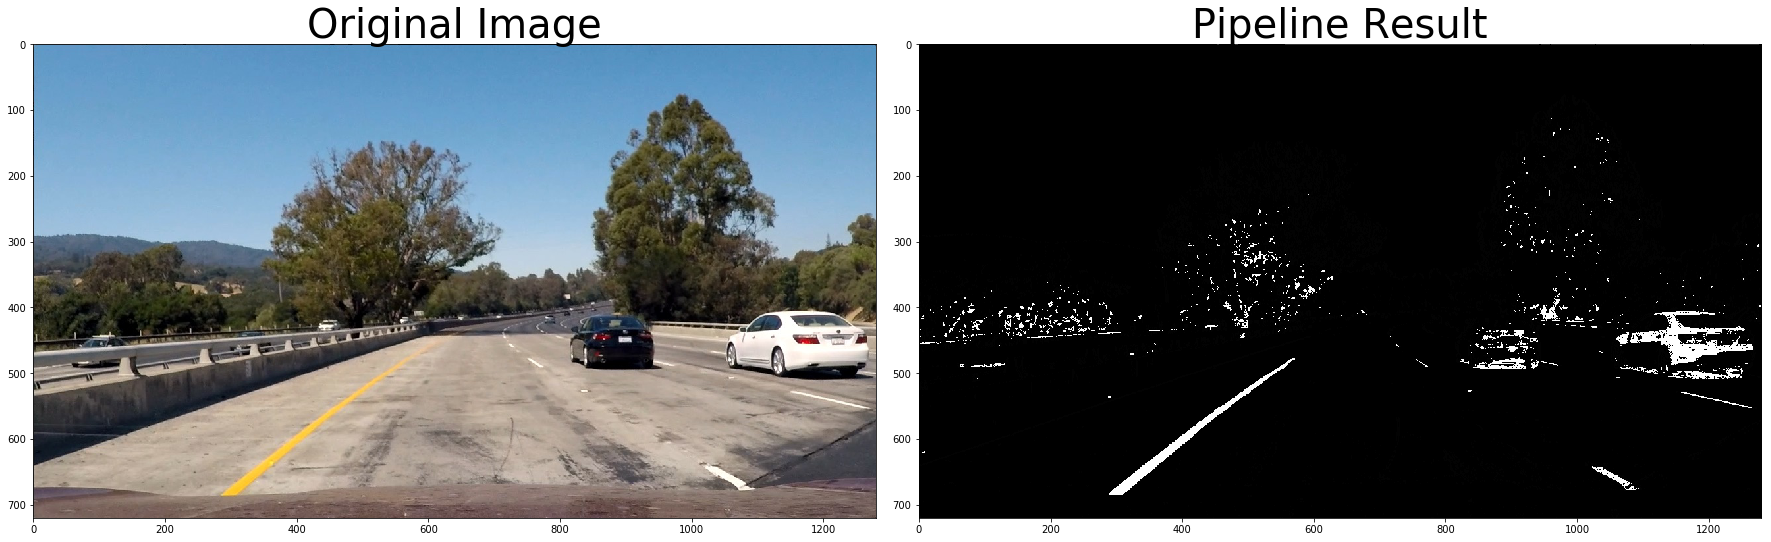

In [52]:
import matplotlib.image as mpimg
image = mpimg.imread('./test_images/test1.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # gray scale
    binary_img = cv2.cvtColor(color_binary, cv2.COLOR_BGR2GRAY)
    # make it brighter
    binary_img[binary_img > 90] = 1
    return binary_img
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, 'gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

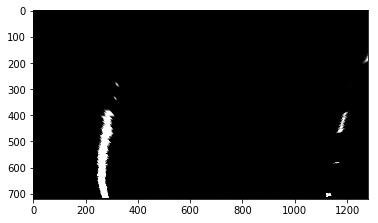

In [53]:
# Show all the after thresholds images with perspective view
plt.imshow(cv2.warpPerspective(result, M, (1280, 720)), 'gray')

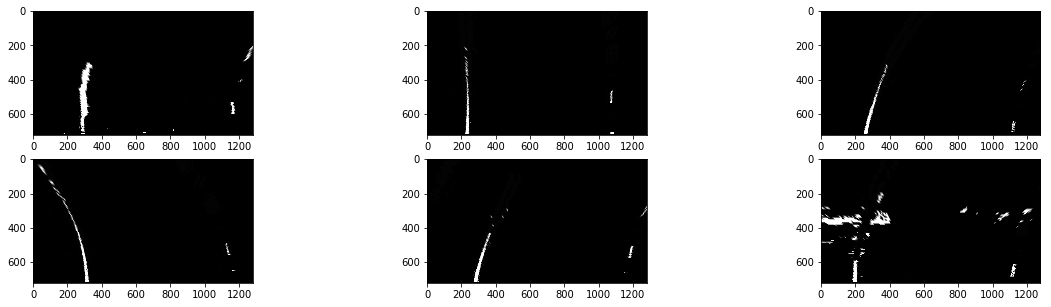

In [54]:
show_images([cv2.warpPerspective(pipeline(image), M, (1280, 720)) for image in test_images_list], 3)

In [55]:
perspectived_imglist = [cv2.warpPerspective(pipeline(image), M, (1280, 720)) for image in test_images_list]

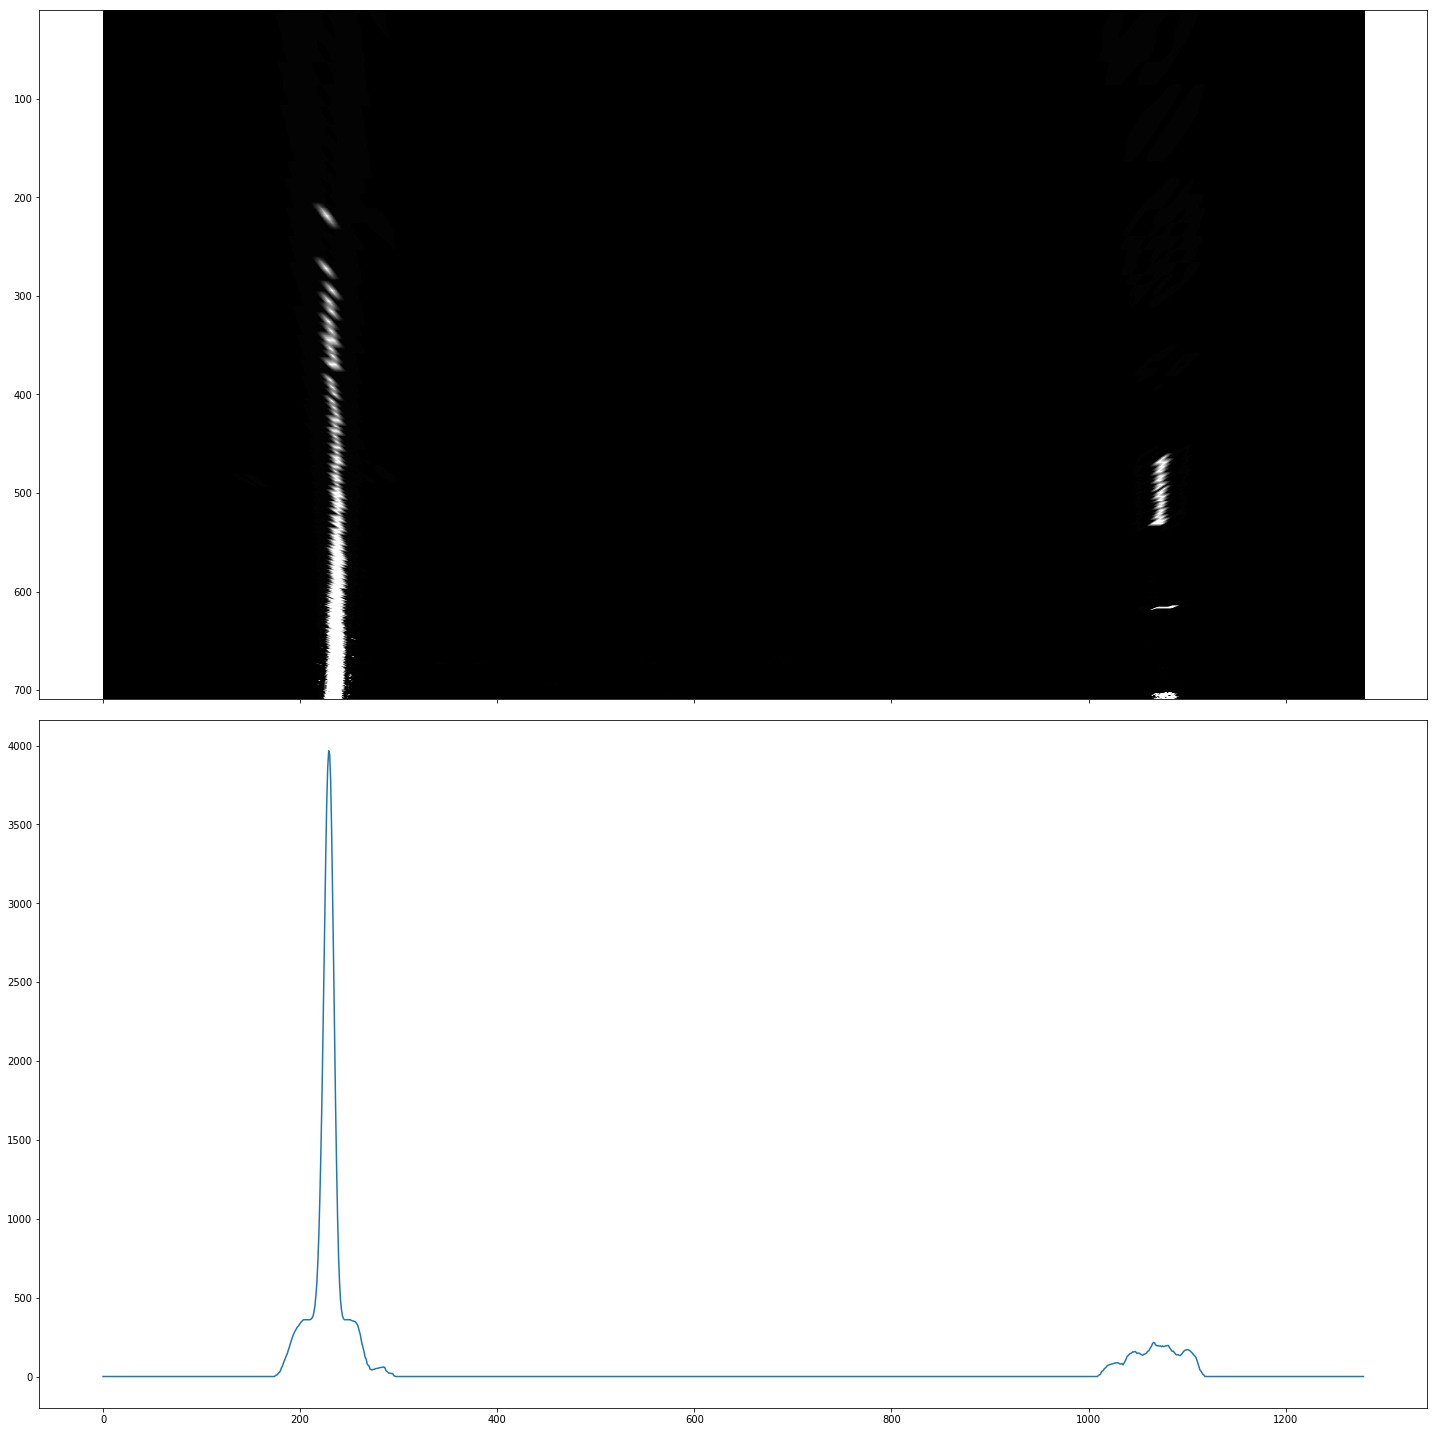

In [56]:
# Histogram
def hist(img):
    shape = img.shape
    middle_point = shape[0] // 2
    left = np.sum(img[:middle_point, :], axis=0)
    return left
# test
index = 2
fig, axes = plt.subplots(2, figsize=(20, 20), sharex=True)
fig.tight_layout()
axes[0].imshow(perspectived_imglist[index], 'gray')
axes[1].plot(hist(perspectived_imglist[index]))

In [64]:
# Load our image
# binary_warped = mpimg.imread('warped_example.jpg')

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 12
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        # binary_warped.shape[0] = 720
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [ ]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

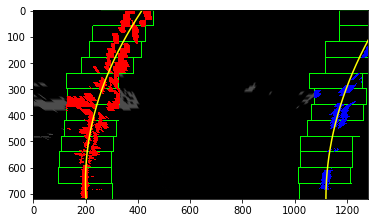

In [71]:
binary_warped = perspectived_imglist[6]
plt.imshow(fit_polynomial(binary_warped))
# show_images([fit_polynomial(img) for img in perspectived_imglist], 3)